In [1]:
from PIL import Image
import numpy as np
import os
# import keras
# from keras import tf
# from keras import layers
# from keras import models
# from keras import regularizers

import pprint
import matplotlib.pyplot as plt
import skimage as ski

#Additions for overfitting
# from tensorflow.keras.callbacks import EarlyStopping
# from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping


# Resize Data #

In [2]:


def resize_images(input_dir, output_dir, width, height):
    for filename in os.listdir(input_dir):
        img_path = os.path.join(input_dir, filename)
        try:
            with Image.open(img_path) as img:
                resized = img.resize((width, height), Image.BILINEAR)
                resized.save(os.path.join(output_dir, filename))
        except Exception as e:
            print(f"Could not process {filename}: {e}")


In [3]:
# notebook_dir = os.getcwd()
# resize_images(os.path.join(notebook_dir, "signatures/full_forg"), os.path.join(notebook_dir, "signatures/resized_forg"), 220, 155)

### Clean Resized Data ###

In [4]:
FORG_DATA_PATH = "signatures/resized_forg"
ORG_DATA_PATH = "signatures/resized_org"


'''
For each image, 
    converts to black and white, 
    turns into an np array, and 
    stores it in dict as:
        forgeries[IMAGE_NAME]
            or
        originals[IMAGE_NAME]
'''
forgeries = {}
for filename in os.listdir(FORG_DATA_PATH):
    name = filename.split(".")[0]
    filepath = FORG_DATA_PATH + "/" + filename
    with Image.open(filepath) as img:
        # Manual conversion to B&W using otsu thresholding
        greyscale = img.convert('L')
        threshold = ski.filters.threshold_otsu(np.asarray(greyscale))
        thresholded = greyscale.point( lambda p: 255 if p > threshold else 0 )
        black_and_white = thresholded.convert('1')  

        forgeries[name] = np.array(black_and_white)

originals = {}
for filename in os.listdir(ORG_DATA_PATH):
    name = filename.split(".")[0]
    filepath = ORG_DATA_PATH + "/" + filename
    with Image.open(filepath) as img:
        # Manual conversion to B&W using otsu thresholding
        greyscale = img.convert('L')
        hreshold = ski.filters.threshold_otsu(np.asarray(greyscale))
        thresholded = greyscale.point( lambda p: 255 if p > threshold else 0 )
        black_and_white = thresholded.convert('1') 

        originals[name] = np.array(black_and_white)





### Format into testing/training data ###

In [5]:
# Reformat into sig_dict[user_id] -> {"originals": {}, "forgeries", {}}

sig_dict = {}

for key in forgeries.keys():
    user_id = key.split("_")[1]
    sig_number = key.split("_")[2]

    if user_id in sig_dict.keys():
        sig_dict[user_id]["forgeries"][sig_number] = forgeries[key]
    else:
        sig_dict[user_id] = {"forgeries" : {sig_number : forgeries[key]},
                             "originals" : {}
                             }

for key in originals.keys():
    user_id = key.split("_")[1]
    sig_number = key.split("_")[2]
    sig_dict[user_id]["originals"][sig_number] = originals[key]
    # sig_dict[user_id]["originals"][sig_number] = "org"

'''    
Current format:
sig_dict = {
    [user number] : { 
            "forgeries" : {"1": [first_forgery],
                           "2": [second_forgery],
                           ...},
            "originals" : "1": [first_original],
                           "2": [second_original],
                           ...}
            }
    "2" : { ...
    }
'''


'    \nCurrent format:\nsig_dict = {\n    [user number] : { \n            "forgeries" : {"1": [first_forgery],\n                           "2": [second_forgery],\n                           ...},\n            "originals" : "1": [first_original],\n                           "2": [second_original],\n                           ...}\n            }\n    "2" : { ...\n    }\n'

In [6]:
x_train, y_train = [], []
x_test, y_test = [], []

# labels: 1 == genuine:genuine, 0 == genuine:forgery
# The first 44 users will be train and the remaining 11 will be in testing

for user_id in sig_dict.keys():
    user_sigs = sig_dict[user_id]

    if int(user_id) <= 44: 
        # TRAINING DATA

        for reference_sig_id in user_sigs["originals"]:
            reference_original = user_sigs["originals"][reference_sig_id]

            # Iterate through all other signatures and make a data point
            # Originals
            for org_id in user_sigs["originals"]:
                if org_id == reference_sig_id: continue
                org_image = user_sigs["originals"][org_id]

                x_train.append((reference_original, org_image))
                y_train.append(1)
            
            # Forgeries
            for forg_id in user_sigs["forgeries"]:
                forg_image = user_sigs["forgeries"][forg_id]

                x_train.append((reference_original, forg_image))
                y_train.append(0)


    else:
        #TESTING
        
        for reference_sig_id in user_sigs["originals"]:
            reference_original = user_sigs["originals"][reference_sig_id]

            # Iterate through all other signatures and make a data point
            # Originals
            for org_id in user_sigs["originals"]:
                if org_id == reference_sig_id: continue
                org_image = user_sigs["originals"][org_id]

                x_test.append((reference_original, org_image))
                y_test.append(1)
            
            # Forgeries
            for forg_id in user_sigs["forgeries"]:
                forg_image = user_sigs["forgeries"][forg_id]

                x_test.append((reference_original, forg_image))
                y_test.append(0)

x_train = np.array(x_train, dtype='float32')
y_train = np.array(y_train, dtype='float32')
x_test = np.array(x_test, dtype='float32')
y_test = np.array(y_test, dtype='float32')
    

In [7]:
x_train.shape
x_test.shape

(12408, 2, 155, 220)

In [8]:
x_train_1 = x_train[:, 0]
x_train_2 = x_train[:, 1]

x_test_1 = x_test[:, 0]
x_test_2 = x_test[:, 1]

print(x_train_1.shape)
print(x_test_1.shape)

print(x_train_2.shape)
print(x_test_2.shape)

(49632, 155, 220)
(12408, 155, 220)
(49632, 155, 220)
(12408, 155, 220)


In [9]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

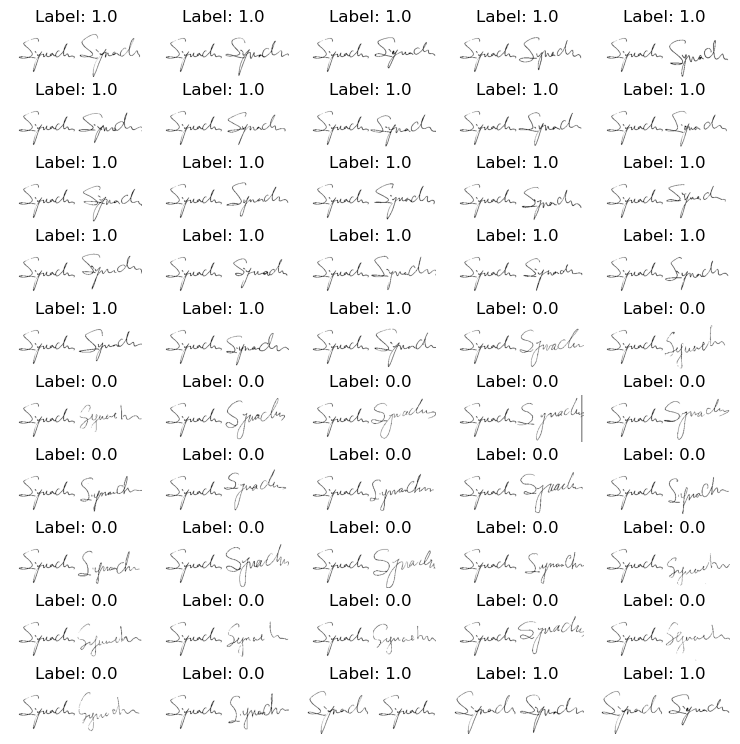

In [10]:
visualize(x_train[:-1], y_train[:-1], to_show=50, num_col=5)

In [11]:
def euclidean_dist(vectors):
    x, y = vectors
    return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True), keras.backend.epsilon()))

In [12]:
# base_model = models.Sequential([
#     layers.Input((155, 220, 1)),
#     layers.Conv2D(96, (11, 11), activation='relu', strides=4, padding='same'),
#     layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
#     layers.MaxPooling2D((3,3), strides=(2, 2)),
#     layers.ZeroPadding2D((2, 2)),

#     layers.Conv2D(256, kernel_size=(5, 5), activation='relu', strides=1),
#     layers.BatchNormalization(epsilon=1e-06, axis=-1, momentum=0.9),
#     layers.MaxPooling2D((3,3), strides=(2, 2)),
#     layers.Dropout(0.3),
#     layers.ZeroPadding2D((1, 1)),


#     layers.Conv2D(384, kernel_size=(3, 3), activation='relu', strides=1),
#     layers.ZeroPadding2D((1, 1)),

#     layers.Conv2D(384, kernel_size=(3, 3), activation='relu', strides=1),
#     layers.MaxPooling2D((3,3), strides=(2,2)),
#     layers.Dropout(0.3),
#     layers.Flatten(),
#     layers.Dense(1024, activation='relu'),
#     layers.Dropout(0.5),

#     layers.Dense(128, activation='relu')])

# base_model = models.Sequential([
#     layers.Input((155, 220, 1)),

#     layers.Conv2D(96, (11, 11), activation='relu', strides=4, padding='same',
#                   kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
#     layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
#     layers.MaxPooling2D((3, 3), strides=(2, 2)),
#     layers.ZeroPadding2D((2, 2)),

#     layers.Conv2D(256, kernel_size=(5, 5), activation='relu', strides=1,
#                   kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
#     layers.BatchNormalization(epsilon=1e-06, axis=-1, momentum=0.9),
#     layers.MaxPooling2D((3, 3), strides=(2, 2)),
#     layers.Dropout(0.3),
#     layers.ZeroPadding2D((1, 1)),

#     layers.Conv2D(384, kernel_size=(3, 3), activation='relu', strides=1,
#                   kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
#     layers.ZeroPadding2D((1, 1)),

#     layers.Conv2D(384, kernel_size=(3, 3), activation='relu', strides=1,
#                   kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
#     layers.MaxPooling2D((3, 3), strides=(2, 2)),
#     layers.Dropout(0.3),

#     layers.Flatten(),

#     layers.Dense(1024, activation='relu', 
#                  kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
#     layers.Dropout(0.5),

#     layers.Dense(128, activation='relu', 
#                  kernel_regularizer=regularizers.l2(0.01))  # L2 regularization
# ])

# # '''
# base_model = models.Sequential([
#     layers.Input((155, 220, 1)),
#     layers.Conv2D(32, (7, 7), activation='relu', strides=2, padding='same'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),

#     layers.Conv2D(64, (5, 5), activation='relu', strides=1),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.2),

#     layers.Conv2D(128, (3, 3), activation='relu', strides=1),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.3),

#     layers.Flatten(),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(128, activation='relu')
# ])
# # '''

# base_model = models.Sequential([
#     layers.Input((155, 220, 1)),
#     layers.Conv2D(32, (7, 7), strides=2, padding='same'),
#     layers.BatchNormalization(),  # BatchNormalization placed after Conv2D
#     layers.ReLU(),                # Activation function placed after BatchNormalization
#     layers.MaxPooling2D((2, 2)),

#     layers.Conv2D(64, (5, 5), strides=1),
#     layers.BatchNormalization(),
#     layers.ReLU(),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.2),

#     layers.Conv2D(128, (3, 3), strides=1),
#     layers.BatchNormalization(),  # BatchNormalization placed after Conv2D
#     layers.ReLU(),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.3),

#     layers.Flatten(),
#     layers.Dense(256),
#     layers.BatchNormalization(),
#     layers.ReLU(),
#     layers.Dropout(0.5),
#     layers.Dense(128)
# ])

base_model = models.Sequential([
    layers.Input((155, 220, 1)),
    layers.Conv2D(96, (11, 11), activation='relu', strides=4, padding='same', kernel_regularizer = "L2"),
    layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
    layers.MaxPooling2D((3,3), strides=(2, 2)),
    layers.ZeroPadding2D((2, 2)),

    layers.Conv2D(256, kernel_size=(5, 5), activation='relu', strides=1, kernel_regularizer = "L2"),
    layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
    layers.MaxPooling2D((3,3), strides=(2, 2)),
    layers.Dropout(0.2),
    layers.ZeroPadding2D((1, 1)),


    layers.Conv2D(384, kernel_size=(3, 3), activation='relu', strides=1, kernel_regularizer = "L2"),
    layers.ZeroPadding2D((1, 1)),

    layers.Conv2D(256, kernel_size=(3, 3), activation='relu', strides=1, kernel_regularizer = "L2"),
    layers.MaxPooling2D((3,3), strides=(2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(1028, activation='relu', kernel_regularizer = "L2"),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu', kernel_regularizer = "L2")])

In [13]:
# input_1 = keras.layers.Input((155, 220, 1))
# input_2 = keras.layers.Input((155, 220, 1))



# siamese_1 = base_model(input_1)
# siamese_2 = base_model(input_2)

# merge_layer = keras.layers.Lambda(euclidean_dist, output_shape=(1,))([siamese_1, siamese_2])
# normalization_layer = keras.layers.BatchNormalization()(merge_layer)
# output_layer = keras.layers.Dense(1, activation="sigmoid")(normalization_layer)
# siamese_network = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

## Jack
input_1 = keras.layers.Input((155, 220, 1))
input_2 = keras.layers.Input((155, 220, 1))

siamese_1 = base_model(input_1)
siamese_2 = base_model(input_2)

merge_layer = keras.layers.Lambda(euclidean_dist, output_shape=(1,))([siamese_1, siamese_2])
normalization_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normalization_layer)
siamese_network = keras.Model(inputs=[input_1, input_2], outputs=output_layer)



In [14]:
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - (y_pred), 0))
        return tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

In [15]:
margin = 1

In [16]:
# siamese_network.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese_network.compile(loss=loss(margin=margin), optimizer="Adam", metrics=["accuracy"])
siamese_network.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 155, 220,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 155, 220,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │  8,845,484 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,845,490 (33.74 MB)

 Trainable params: 8,845,372 (33.74 MB)

 Non-trainable params: 118 (472.00 B)

In [17]:
x_train_1[0].shape

(155, 220)

In [18]:
epochs = 10
# batch_size = 256
batch_size = 64

In [19]:
# Added early stopping to combat overfitting
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

In [20]:
#Trying to fix warning message
assert isinstance(x_train_1, np.ndarray)
assert isinstance(x_train_2, np.ndarray)

In [21]:
# print(x_train_1.shape)  # Should be (num_samples, 155, 220, 1)
# print(x_train_2.shape)  # Same shape
# print(y_train.shape)    # Should be (num_samples,) or (num_samples, 1)

x_train_1 = np.expand_dims(x_train_1, axis=-1)
x_train_2 = np.expand_dims(x_train_2, axis=-1)
x_test_1 = np.expand_dims(x_test_1, axis=-1)
x_test_2 = np.expand_dims(x_test_2, axis=-1)

# print(x_train_1.shape)  # Should be (num_samples, 155, 220, 1)
# print(x_train_2.shape)  # Same shape
# print(y_train.shape)    # Should be (num_samples,) or (num_samples, 1




In [22]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_batch(images, augment_factor=2, batch_size=128):
    """
    Augments a batch of images using ImageDataGenerator.

    Args:
        images (np.ndarray): Original images, shape (N, H, W, C)
        augment_factor (int): How many new versions to create per original
        batch_size (int): Batch size to use in generator

    Returns:
        np.ndarray: Augmented dataset with (augment_factor + 1) * N samples
    """
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.02,
        zoom_range=0.05,
        fill_mode='nearest'
    )

    augmented_images = [images]  # Start with the original data
    steps = int(np.ceil(len(images) / batch_size))

    for _ in range(augment_factor):
        gen = datagen.flow(images, batch_size=batch_size, shuffle=False)
        aug = np.concatenate([next(gen) for _ in range(steps)], axis=0)
        augmented_images.append(aug[:len(images)])  # Slice in case extra from last batch

    return np.concatenate(augmented_images, axis=0)

In [23]:
# Show Augmented Data


def show_random_augmentation(x_train_2_augmented):
    # Randomly choose one index from the augmented data
    half = len(x_train_2_augmented)//2
    idx = np.random.randint(0, half)  # Index is in the first half of the augmented set
    
    # Select the original and augmented images
    original_image = x_train_2_augmented[idx]
    augmented_image = x_train_2_augmented[idx + half]

    # Ensure the images are single-channel (grayscale)
    if original_image.ndim == 3 and original_image.shape[-1] != 1:
        # Convert to grayscale if there are multiple channels (e.g., RGB)
        original_image = np.mean(original_image, axis=-1, keepdims=True)
    if augmented_image.ndim == 3 and augmented_image.shape[-1] != 1:
        # Convert to grayscale if there are multiple channels (e.g., RGB)
        augmented_image = np.mean(augmented_image, axis=-1, keepdims=True)

    # Normalize the image if necessary (check for values above 1.0)
    if np.max(original_image) > 1.0:
        original_image = original_image / 255.0
    if np.max(augmented_image) > 1.0:
        augmented_image = augmented_image / 255.0

    # Display the images side by side (black and white)
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.squeeze(), cmap='gray')  # Use 'gray' colormap for grayscale
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image.squeeze(), cmap='gray')  # Use 'gray' colormap for grayscale
    plt.title("Augmented Image")
    plt.axis('off')
    
    plt.show()


In [24]:
AUGMENTATION_FACTOR = 2

AUGMENT_X1 = True
AUGMENT_X2 = False

ONLY_AUGMENT_X1_AND_REPLACE_ORIGINALS = True

if ONLY_AUGMENT_X1_AND_REPLACE_ORIGINALS:
    x_train_1_augmented = augment_batch(x_train_1, augment_factor=(AUGMENTATION_FACTOR - 1))
    x_train_1_augmented = x_train_1_augmented[len(x_train_1):] #Replace old data

    x_train_2_augmented = x_train_2
    y_train_augmented = y_train

else:

    ''' Repeat x_train_1 _ times'''
    if AUGMENT_X1:
        ''' AUGMENT x_train_1 as well'''
        x_train_1_augmented = augment_batch(x_train_1, augment_factor=(AUGMENTATION_FACTOR - 1))
        print("Augmentation of x1 complete.")
        print(f"\tx_train_1_augmented shape: {x_train_1_augmented.shape}")
        show_random_augmentation(x_train_1_augmented)
    else:
        x_train_1_augmented = np.tile(x_train_1, (AUGMENTATION_FACTOR, 1, 1, 1))  # unchanged
        print("Augmentation of x1 complete.")
        print(f"\tx_train_1_augmented shape: {x_train_1_augmented.shape}")


    if AUGMENT_X2:
        x_train_2_augmented = augment_batch(x_train_2, augment_factor=(AUGMENTATION_FACTOR - 1))
        print("Augmentation of x2 complete.")
        print(f"\tx_train_2_augmented shape: {x_train_2_augmented.shape}")
        show_random_augmentation(x_train_2_augmented)
    else:
        x_train_2_augmented = np.tile(x_train_2, (AUGMENTATION_FACTOR, 1, 1, 1))  # unchanged


    y_train_augmented = np.tile(y_train, AUGMENTATION_FACTOR)

print("Augmentation of all data complete.")
print(f"\tx_train_1_augmented shape: {x_train_1_augmented.shape}")
print(f"\tx_train_2_augmented shape: {x_train_2_augmented.shape}")
print(f"\ty_train_augmented shape: {y_train_augmented.shape}")

Augmentation of all data complete.
	x_train_1_augmented shape: (49632, 155, 220, 1)
	x_train_2_augmented shape: (49632, 155, 220, 1)
	y_train_augmented shape: (49632,)


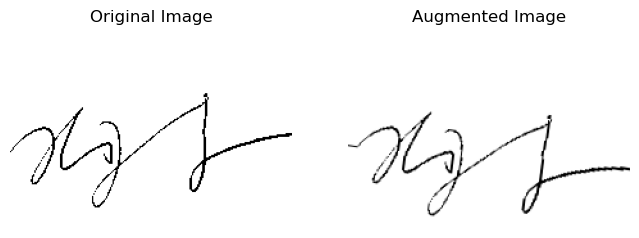

In [25]:
# Check out augmentations
# show_random_augmentation(x_train_2_augmented)
show_random_augmentation(np.concatenate((x_train_1, x_train_1_augmented), axis=0))

In [26]:



# history = siamese_network.fit(
#     (x_train_1_augmented, x_train_2_augmented),
#     y_train_augmented,
#     validation_data=((x_test_1, x_test_2), y_test),
#     batch_size=batch_size,
#     epochs=epochs,
#     callbacks=[early_stopping],
# )

## Jack

epochs = 8
batch_size = 64

history = siamese_network.fit(
    [x_train_1_augmented, x_train_2_augmented],
    y_train_augmented,
    validation_data=([x_test_1, x_test_2], y_test),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
)


Epoch 1/8
776/776 ━━━━━━━━━━━━━━━━━━━━ 1382s 2s/step - accuracy: 0.5103 - loss: 2.0142 - val_accuracy: 0.5106 - val_loss: 0.2504
Epoch 2/8
776/776 ━━━━━━━━━━━━━━━━━━━━ 1471s 2s/step - accuracy: 0.5081 - loss: 0.2506 - val_accuracy: 0.5106 - val_loss: 0.2503
Epoch 3/8
776/776 ━━━━━━━━━━━━━━━━━━━━ 1610s 2s/step - accuracy: 0.5098 - loss: 0.2501 - val_accuracy: 0.5106 - val_loss: 0.2499
Epoch 4/8
776/776 ━━━━━━━━━━━━━━━━━━━━ 1446s 2s/step - accuracy: 0.5070 - loss: 0.2500 - val_accuracy: 0.5106 - val_loss: 0.2499
Epoch 5/8
111/776 ━━━━━━━━━━━━━━━━━━━━ 20:10 2s/step - accuracy: 0.5164 - loss: 0.2498

KeyboardInterrupt: 